In [ ]:
!pip3 install -Uqq fastai

     |████████████████████████████████| 194kB 24.0MB/s 
     |████████████████████████████████| 61kB 8.6MB/s 


In [ ]:
import fastai
fastai.__version__

'2.4'

In [ ]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [ ]:
from fastai.text.all import *
import pandas as pd
import numpy as np

In [ ]:
path = Path('/content/gdrive/MyDrive/subcellular-location/v2')

In [ ]:
Path.BASE_PATH = path

In [ ]:
path.ls()

(#5) [Path('LM_data_2021-03-11.csv'),Path('proteinClassifier.ipynb'),Path('data'),Path('models'),Path('AA_LM_model.pk')]

In [ ]:
data = path / Path('data/raw/LM_data_2021-03-11.csv')

In [ ]:
df = pd.read_csv(data, sep=';')
df.head()

,Entry,Entry name,Sequence
0,P68307,NU3M_BALMU,MNLLLTLLTNTTLALLLVFIAFWLPQLNVYAEKTSPYECGFDPMGSARLPFSMKFFLVAITFLLFDLEIALLLPLPWAIQSNNLNTMLTMALFLISLLAASLAYEWTQEGLEWAE
1,P0CY61,O162_CONBU,MKLTCVLIIAVLFLTAITADDSRDKQVYRAVGLIDKMRRIRASEGCRKKGDRCGTHLCCPGLRCGSGRAGGACRPPYN
2,Q0VIL3,OTOMP_DANRE,MDLPGGHLAVVLFLFVLVSMSTENNIIRWCTVSDAEDQKCLDLAGNATARNLRGQLVCVRGQSPTDCMKQIKNGTADASTMYADEIYTAGFCYGLDVAVGESYNGVDGINYYVVALARTSSSDLSLLEMHERSSCHPGMRTTVGWTVPIGFLVNTSQISVDVQCNFPHAVGDFFGYSCVPGVKDPEHDPKGNNPRNLCEACIGDENDRHICANNPRERHFGEAGALRCVAENLGDVAFVKHTTVFDNMQGKNQESWALDLELEDLKLLCPDGSEANLFQHESCHLAVVPTNAVVVRLEDKCRVYKFLERVQNAFGNTTEGFSLFSSVNYGQPDVLFSDSTKKLLRVMGTYTSWLGPSYTTILRAFECEGLC
3,A1W9I4,NUSB_ACISJ,MTDSTHPTPSARPPRQPRTGTTGTGARKAGSKSGRSRAREFALQALYQHLVGGNDATAIDVFTRDLSGFHKADAAHYDALLHGCITTAQYMDELIAPQLDRKMSEISPIEHAVMWIGVYEFQHCQDVPWRVVINECIELAKEFGGTDGHKYVNGVLNGLAPQLRATEVAADKAAARG
4,Q8DBX0,OMPU_VIBVU,MKKTLIALSVSAAAVATGVNAAELYNQDGTSLDMGGRAEARLSMKDGKVADNSRIRLNFLGKVEIQDGLYGVGFYEGEFTTADNADGSDLDNRYTYAGLGGKFGEVTYGKNDGALGVITDFTDIMAYHGNSAADKIAVADRVDNMMSYKGQFDALSVKASYRFADRADSSKNNVDNTYIDNGKDGYSLSAIYAIGQTGLTLGGGYADQDKSNEYMLAASYTMGDLYFAGVFTDGEKDYGTNGDYSHRGFSSVEDYTGYELAAKYTMGQTVFTTTYNNAETDGYTSTDNFAVDATYYFKPNFRGYVSYNFNLLDAGDKIGTSTISKADAEDELALGLRYDF


In [ ]:
mini_data = df[:1000]
mini_data.shape

(1000, 3)

In [ ]:
KMER_SIZE = 1 # One AA at the time

In [ ]:
class AATokenizer():
  "Tokenizer for Amino Acids"

  def __init__(self, kmer_size=1, stride=1):
    self.kmer_size = kmer_size
    self.stride = stride
  
  def __call__(self, items):
    tokenized = []
    for item in items:
      tokenized_item = []
      for i in range (0, len(item) - self.kmer_size, self.stride):
        kmer = item[i: i + self.kmer_size]
        tokenized_item.append(kmer)

      tokenized.append(tokenized_item)

    return tuple(tokenized)

In [ ]:
tok = AATokenizer(kmer_size=KMER_SIZE)

## Test of zonder rules of met rules beter werkt

In [ ]:
dblock = DataBlock(
    blocks=TextBlock.from_df('Sequence', is_lm=True, tok=tok, rules=[rm_useless_spaces]),
    get_x=ColReader('text'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

In [ ]:
dls = dblock.dataloaders(df, bs=16, shuffle=False)

KeyboardInterrupt: ignored

In [ ]:
dls.show_batch(max_n=2)

In [ ]:
learner = language_model_learner(dls, AWD_LSTM, pretrained=False)

In [ ]:
learner.fit(1)

epoch,train_loss,valid_loss,time
0,2.908503,2.890015,18:21


In [ ]:
dblock2 = DataBlock(
    blocks=TextBlock.from_df('Sequence', is_lm=True, tok=tok),
    get_x=ColReader('text'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

In [ ]:
dls2 = dblock2.dataloaders(df, bs=16, shuffle=False)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
dls2.show_batch(max_n=2)

,text,text_
0,x x b o s ▁ x x u p ▁ m r s ▁ x x r e p ▁ 4 ▁ l ▁ x x u p ▁ a s l a w ▁ x x r e p ▁ 3 ▁ l ▁ x x u p ▁ a q a k d d a k l e d n l l v l t v a t k,x b o s ▁ x x u p ▁ m r s ▁ x x r e p ▁ 4 ▁ l ▁ x x u p ▁ a s l a w ▁ x x r e p ▁ 3 ▁ l ▁ x x u p ▁ a q a k d d a k l e d n l l v l t v a t k e
1,l t a a v s t p a n s l a h s ▁ x x r e p ▁ 4 ▁ l ▁ x x u p ▁ w g p e a q g d f t r w c q l g g l w t f v a l h g a f g l i g f m l r q f e l a,t a a v s t p a n s l a h s ▁ x x r e p ▁ 4 ▁ l ▁ x x u p ▁ w g p e a q g d f t r w c q l g g l w t f v a l h g a f g l i g f m l r q f e l a r


In [ ]:
learner2 = language_model_learner(dls2, AWD_LSTM, pretrained=False)

In [ ]:
learner2.fit(1)

epoch,train_loss,valid_loss,time
0,2.786234,2.744235,18:23


## Conclusie, met rules werkt beter. Trainen met subset data.

Nu eerst even testen op een kleine subset data om te zien of het model beter word.

In [ ]:
dblock = DataBlock(
    blocks=TextBlock.from_df('Sequence', is_lm=True, tok=tok),
    get_x=ColReader('text'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

In [ ]:
dls = dblock.dataloaders(mini_data, bs=16, shuffle=False)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
dls.show_batch(max_n=2)

,text,text_
0,x x b o s ▁ x x u p ▁ m r s ▁ x x r e p ▁ 4 ▁ l ▁ x x u p ▁ a s l a w ▁ x x r e p ▁ 3 ▁ l ▁ x x u p ▁ a q a k d d a k l e d n l l v l t v a t k,x b o s ▁ x x u p ▁ m r s ▁ x x r e p ▁ 4 ▁ l ▁ x x u p ▁ a s l a w ▁ x x r e p ▁ 3 ▁ l ▁ x x u p ▁ a q a k d d a k l e d n l l v l t v a t k e
1,l t a a v s t p a n s l a h s ▁ x x r e p ▁ 4 ▁ l ▁ x x u p ▁ w g p e a q g d f t r w c q l g g l w t f v a l h g a f g l i g f m l r q f e l a,t a a v s t p a n s l a h s ▁ x x r e p ▁ 4 ▁ l ▁ x x u p ▁ w g p e a q g d f t r w c q l g g l w t f v a l h g a f g l i g f m l r q f e l a r


In [ ]:
learner = language_model_learner(dls, AWD_LSTM, pretrained=False, metrics=[accuracy])

SuggestedLRs(valley=tensor(0.0005))

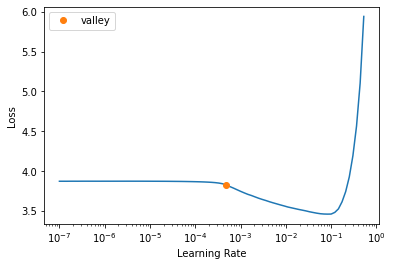

In [ ]:
learner.lr_find()

In [ ]:
learner.fit_one_cycle(5, lr_max=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.086429,3.070463,0.089846,00:27
1,3.074936,3.067664,0.089858,00:28
2,3.060845,3.055232,0.073864,00:28
3,3.051248,3.046469,0.089858,00:28
4,3.044646,3.040527,0.089858,00:28


## Conclusie, met trainen gaat de los vooruit. Nu dus trainen op complete dataset.

In [ ]:
dblock = DataBlock(
    blocks=TextBlock.from_df('Sequence', is_lm=True, tok=tok),
    get_x=ColReader('text'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

In [ ]:
dls = dblock.dataloaders(df, bs=16, shuffle=False)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
dls.show_batch(max_n=2)

,text,text_
0,x x b o s ▁ x x u p ▁ m l t w v i r v c f l i l g g t t g v f s l p a l w v k l g i g h i l l i n n p y t d a l i g a l i f y l i t f w a v k y,x b o s ▁ x x u p ▁ m l t w v i r v c f l i l g g t t g v f s l p a l w v k l g i g h i l l i n n p y t d a l i g a l i f y l i t f w a v k y v
1,q p a g r p n p s s f l l s w s e e s t d g s c f h g h s l k g i l q e k h g l l t a i n t d y w l c t d k l c n e k l c g h l a h y r e e d f,p a g r p n p s s f l l s w s e e s t d g s c f h g h s l k g i l q e k h g l l t a i n t d y w l c t d k l c n e k l c g h l a h y r e e d f p


In [ ]:
# To fp16 makes the model train faster, since there are less decimals
learner = language_model_learner(dls, AWD_LSTM, pretrained=False, metrics=[accuracy]).to_fp16()

Even uitzoeken of er layers gefreezed zijn

In [ ]:
for _, layer in enumerate(learner.model.parameters()):
  print(layer.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True


Alles staat op requires_grad true omdat het geen pretrained model is :)

SuggestedLRs(valley=tensor(0.0010))

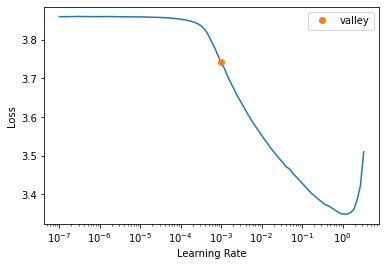

In [ ]:
learner.lr_find()

In [ ]:
filename = 'LM_KMER_1_'

In [ ]:
for i in range(1, 11):
  learner.fit_one_cycle(1, lr_max=1e-3)
  out_filename = filename + 'epoch_' + str(i)
  learner.save(out_filename)

epoch,train_loss,valid_loss,accuracy,time
0,2.390124,2.295155,0.301623,53:21


epoch,train_loss,valid_loss,accuracy,time
0,2.397680,2.294466,0.300953,53:23


epoch,train_loss,valid_loss,accuracy,time
0,2.423069,2.331090,0.289383,53:14


epoch,train_loss,valid_loss,accuracy,time
0,2.454859,2.371319,0.276884,53:08


epoch,train_loss,valid_loss,accuracy,time
0,2.467641,2.382969,0.273527,53:16


epoch,train_loss,valid_loss,accuracy,time


epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: ignored